# 1) What is the mechanism used by the Voting Classifier to aggregate predictions from multiple base models and their differences? Explain with suitable example. If predictions conflict among the base models, what strategies can be employed to resolve the conflicts and make more reliable final predictions in the Voting Classifier? 

# 2) Prove that Elastic net can be used as either LASSO or Ridge regulariser.

Elastic Net regularization is a linear combination of L1 and L2 regularization. Its objective function can be formulated as:

$$
J(\theta) = \mathrm{MSE}(\theta) + r \alpha \sum_{i=1}^{n} |\theta_i| + \frac{1-r}{2} \alpha \sum_{i=1}^{n} \theta_i^2
$$

Where:
- $ J(\theta) $ is the cost function.
- $\mathrm{MSE}(\theta)$ stands for the Mean Squared Error.
- $\alpha$ is the regularization strength, equivalent to $\lambda$ in some formulations.
- $r$ is the mixing parameter between the L1 (LASSO) and L2 (Ridge) penalties. $r$ lies in the range [0,1].
- $\theta$ represents the parameter vector, and the summation runs over all its components.

The two terms added to the MSE represent the L1 and L2 penalties:

1. $ r \alpha \sum_{i=1}^{n} |\theta_i| $ is the L1 penalty (LASSO). Elastic Net behaves as LASSO with a regularization strength of $\alpha$ when $r = 1$.
2. $ \frac{1-r}{2} \alpha \sum_{i=1}^{n} \theta_i^2 $ is the L2 penalty (Ridge). Elastic Net behaves as Ridge regression with a regularization strength of $\alpha$ when $r = 0$.

Based on the mixing parameter $r$:
- When $r = 1$, the Elastic Net objective becomes:

$$
J(\theta) = \mathrm{MSE}(\theta) + \alpha \sum_{i=1}^{n} |\theta_i|
$$

This is essentially the cost function for LASSO regression.

- When $r = 0$, the Elastic Net objective becomes:

$$
J(\theta) = \mathrm{MSE}(\theta) + \frac{1}{2} \alpha \sum_{i=1}^{n} \theta_i^2
$$

This corresponds to the cost function for Ridge regression.

Thus, by varying the parameter $r$, Elastic Net can be tailored to act as either LASSO (for $r = 1$) or Ridge (for $r = 0$) regularization.

Reference:
towards data science, (n.d.). 'Ridge, LASSO, and ElasticNet Regression'. Available at: https://towardsdatascience.com/ridge-lasso-and-elasticnet-regression-b1f9c00ea3a3 [Accessed on: 14 August 2023].



In [142]:
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold

training = pd.read_csv("aps_failure_training_set.csv",  skiprows=20)
test = pd.read_csv("aps_failure_test_set.csv", skiprows=20)

#prepare class:
training["class"] = training["class"].map({'neg':0, 'pos':1})
test["class"] = test["class"].map({'neg':0, 'pos':1})
 
training = training.replace('na',np.NaN)
test = test.replace('na',np.NaN)

y_training = training["class"]
training.drop("class",axis=1, inplace=True)

y_test = test["class"]
test.drop("class",axis=1, inplace=True)

# drop the features with more than 50% of null values on the training set
training = training.loc[:, training.isnull().mean() <= 0.5 ]
test = test[training.columns]

#Replace the outstanding by the means of the column.
impouter = SimpleImputer(strategy="median")
ttemp = pd.DataFrame(impouter.fit_transform(training))
testemp = pd.DataFrame(impouter.fit_transform(test))
ttemp.columns = training.columns
testemp.columns = training.columns
ttemp.index = training.index
testemp.index = test.index
training = ttemp
test = testemp
# removing features with zero variance
selector = VarianceThreshold()
selector.fit_transform(training)
selected_columns = training.columns[(selector.get_support())]
print("dropped columns:", len(set(training.columns) - set(selected_columns)))

training = training[selected_columns]
test = test[training.columns]
print(training.shape)
print(test.shape)

dropped columns: 1
(60000, 161)
(16000, 161)


# 3) Analyse the importance of the features for predicting “class” using two different approaches. Explain the similarity/difference between outcomes.

    Feature    Importance
83   cf_000 -2.317268e-05
49   az_008 -9.061393e-06
7    ag_002  7.311875e-06
131  dl_000 -6.606726e-06
60   ba_009 -4.908950e-06
89   cl_000 -4.744418e-06
28   au_000  3.887212e-06
17   aj_000 -3.436815e-06
143  dy_000 -3.201945e-06
118  cy_000 -2.869821e-06
1    ac_000 -2.433115e-06
5    ag_000 -1.858343e-06
101  co_000 -1.759535e-06
113  cs_009 -1.576012e-06
91   cn_000 -1.535271e-06
142  dx_000 -1.171723e-06
50   az_009 -1.020660e-06
18   ak_000  6.126607e-07
129  dj_000 -4.569964e-07
126  dg_000  4.551900e-07


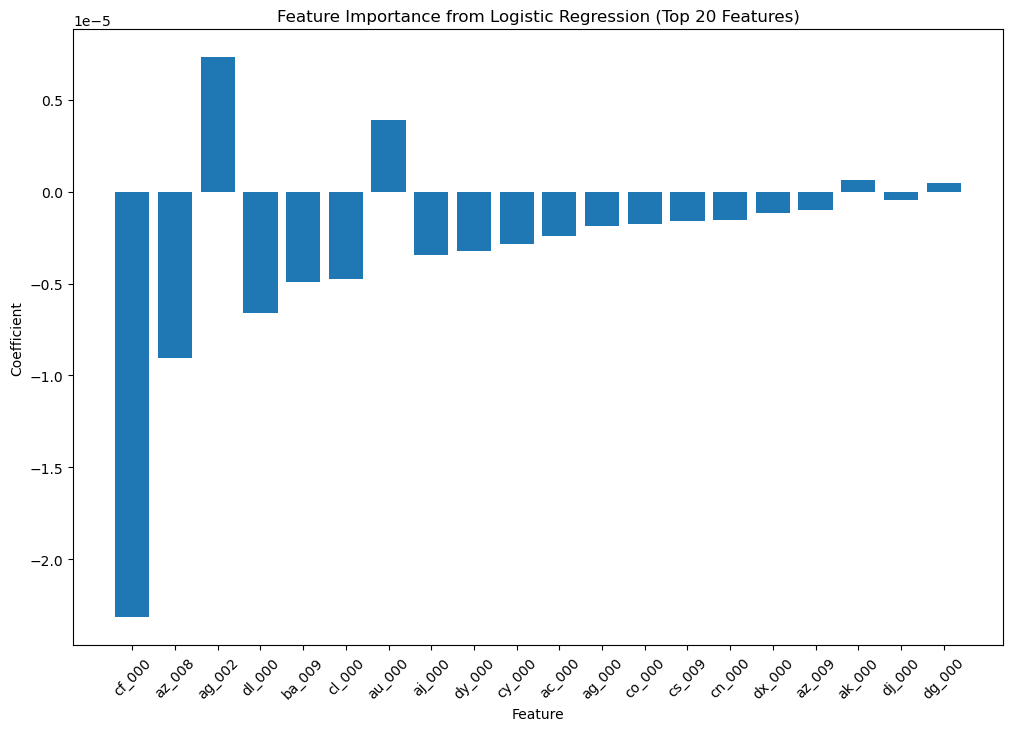

In [143]:
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot as plt

#log
scaler = RobustScaler()
x_log = pd.DataFrame(scaler.fit_transform(training))
logist = LogisticRegression(max_iter=10000)
logist.fit(x_log,y_training)
coefficients = logist.coef_[0]
coeff_df = pd.DataFrame({'Feature': training.columns, 'Importance': coefficients})

# Sort dataframe by absolute coefficient values in descending order
coeff_df = coeff_df.reindex(coeff_df.Importance.abs().sort_values(ascending=False).index)
# Get the first 20 features
top_20_features = coeff_df.iloc[:20]
print(top_20_features)    
# Visualize the coefficients of the first 20 features
plt.figure(figsize=(12, 8))
plt.bar(top_20_features['Feature'], top_20_features['Importance'])
plt.xlabel('Feature')
plt.ylabel('Coefficient')
plt.title('Feature Importance from Logistic Regression (Top 20 Features)')
plt.xticks(rotation=45)
plt.show()    

In [144]:
print("Current N of features:", len(training.columns))

Current N of features: 161


[ 0.00000000e+00 -2.25238979e-09 -0.00000000e+00 -0.00000000e+00
  0.00000000e+00 -1.49699622e-08 -2.66678058e-07  5.66689290e-08
  4.49185983e-08 -0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  5.43060967e-08 -1.15894898e-08  9.44960142e-09  4.43495205e-05
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -2.52423833e-07  3.06767367e-08
  3.39604873e-07  0.00000000e+00  0.00000000e+00  2.16922748e-08
  1.43543197e-08  2.40501817e-09  5.34053329e-08  3.87928076e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.81141185e-08  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00
  1.00530779e-08 -1.00251403e-07  2.19742845e-09  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  3.07889484e-05
 -1.67046317e-06  0.00000

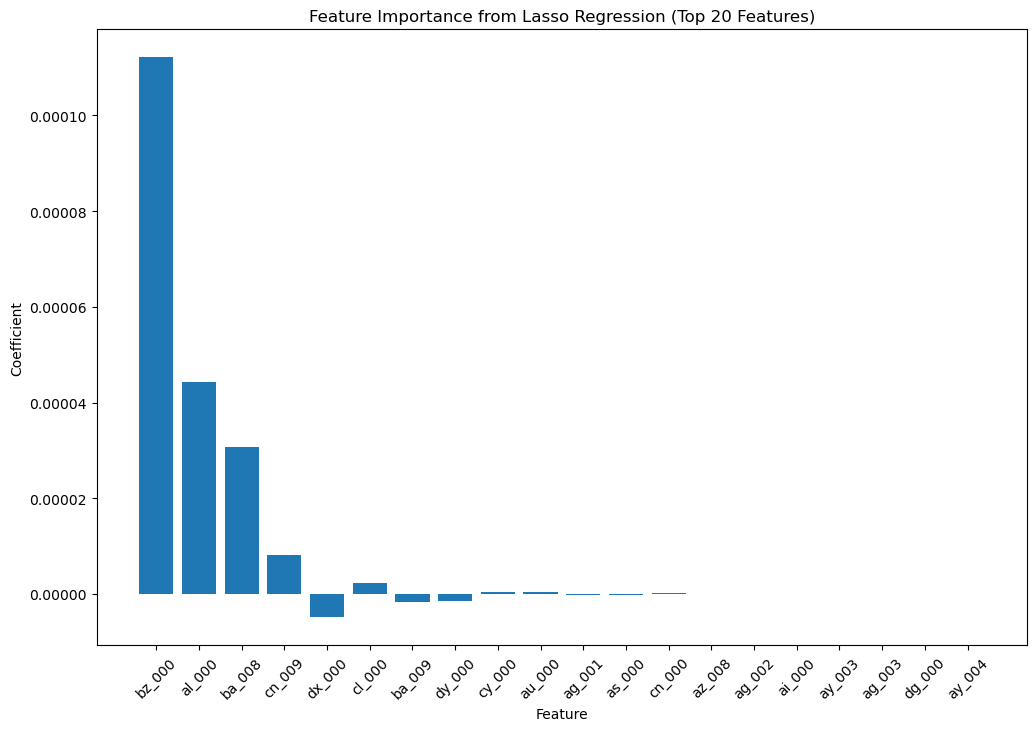

In [145]:
from sklearn.linear_model import Lasso
#Same using Lasso
x_lass = x_log
# Train a Lasso regression model
model = Lasso(alpha=0.5, max_iter=10000)
model.fit(x_lass, y_training)

# Get feature names and coefficients
feature_names = training.columns
coefficients = model.coef_
print(coefficients)
# Create a dataframe for features and their corresponding coefficients
coeff_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

# Filter out features with zero coefficients
non_zero_coeff = coeff_df[coeff_df['Coefficient'] != 0]

# Sort dataframe by absolute coefficient values in descending order
non_zero_coeff = non_zero_coeff.reindex(non_zero_coeff.Coefficient.abs().sort_values(ascending=False).index)

# Get the first 10 features
top_features = non_zero_coeff.iloc[:20]

# Visualize the coefficients of the first10 features
plt.figure(figsize=(12, 8))
plt.bar(top_features['Feature'], top_features['Coefficient'])
plt.xlabel('Feature')
plt.ylabel('Coefficient')
plt.title('Feature Importance from Lasso Regression (Top 20 Features)')
plt.xticks(rotation=45)
plt.show()



# 4. Create three supervised machine learning (ML) models except any ensemble approach for predicting “class''.
a. Report performance score using a suitable metric. Is it possible that the presented result is an overfitted one? Justify.
b. Justify different design decisions for each ML model used to answer this question.
c. Have you optimised any hyper-parameters for each ML model? What are they? Why have you done that? Explain.
d. Finally, make a recommendation based on the reported results and justify it.

In [149]:
#will reuse the already fitted lasso and linear regressions.
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score

selector_lin = SelectFromModel(logist)
selector.fit(x_log,y_training)
status = selector_lin.get_support()
# Use SelectFromModel with the logistic regression model

# Transform the training data
X_lin_selected = selector_lin.transform(training)
X_test_selected = selector_lin.transform(test)

print("Transformed test data:", X_test_selected.shape)
print("Selected features:", training.columns[selector_lin.get_support()])
print("Transformed training data:", X_lin_selected.shape)

X_lin_Test = selector_lin.transform(test)
regressor_selected = LogisticRegression()
regressor_selected.fit(X_lin_selected, y_training)
y_pred = regressor_selected.predict(X_test_selected)

# Calculate metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

# Print metrics to the screen
print(f" Accuracy: {accuracy:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R-squared (R2): {r2:.2f}")



/Users/marsson/anaconda3/envs/m1/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/marsson/anaconda3/envs/m1/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/marsson/anaconda3/envs/m1/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Transformed test data: (16000, 18)
Selected features: Index(['ac_000', 'ag_000', 'ag_002', 'aj_000', 'ak_000', 'au_000', 'az_008', 'az_009', 'ba_009', 'cf_000', 'cl_000', 'cn_000', 'co_000', 'cs_009', 'cy_000', 'dl_000', 'dx_000', 'dy_000'], dtype='object')
Transformed training data: (60000, 18)
 Accuracy: 0.97
Mean Absolute Error (MAE): 0.03
Mean Squared Error (MSE): 0.03
R-squared (R2): -0.36


In [154]:
selector_lass = SelectFromModel(model)
selector_lass.fit(x_lass,y_training)
status_lass = selector_lass.get_support()
# Use SelectFromModel with the lasso regression model

# Transform the training data
X_lass_selected = selector_lass.transform(training)
X_test_lass_selected = selector_lass.transform(test)

print("Transformed test data:", X_test_lass_selected.shape)
print("Selected features:", training.columns[selector_lass.get_support()])
print("Transformed training data:", X_lass_selected.shape)


X_lass_Test = selector_lass.transform(test)
regressor_lass_selected = Lasso(alpha=0.5)
regressor_lass_selected.fit(X_lass_selected, y_training)
y_lass_pred = regressor_lass_selected.predict(X_test_lass_selected)

# Calculate metrics
mae_lass = mean_absolute_error(y_test, y_lass_pred)
mse_lass = mean_squared_error(y_test, y_lass_pred)
r2_lass = r2_score(y_test, y_lass_pred)
#accuracy_lass = accuracy_score(y_test, y_lass_pred)

# Print metrics to the screen
#print(f" Accuracy: {accuracy_lass:.2f}")
print(f"Mean Absolute Error (MAE): {mae_lass:.2f}")
print(f"Mean Squared Error (MSE): {mse_lass:.2f}")
print(f"R-squared (R2): {r2_lass:.2f}")

Transformed test data: (16000, 3)
Selected features: Index(['al_000', 'ba_008', 'bz_000'], dtype='object')
Transformed training data: (60000, 3)
Mean Absolute Error (MAE): 0.03
Mean Squared Error (MSE): 0.02
R-squared (R2): 0.23


/Users/marsson/anaconda3/envs/m1/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/marsson/anaconda3/envs/m1/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/marsson/anaconda3/envs/m1/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


In [157]:
from sklearn.linear_model import SGDClassifier

sgd = SGDClassifier()
selector_sgd = SelectFromModel(sgd)
selector_sgd.fit(x_log,y_training)
status_sgd = selector_sgd.get_support()
# Use SelectFromModel with the logistic regression model

# Transform the training data
X_sgd_selected = selector_sgd.transform(training)
X_test_sgd_selected = selector_sgd.transform(test)

print("Transformed test data:", X_test_sgd_selected.shape)
print("Selected features:", training.columns[selector_sgd.get_support()])
print("Transformed training data:", X_sgd_selected.shape)

X_sgd_Test = selector_sgd.transform(test)
regressor_sgd_selected = SGDClassifier()
regressor_sgd_selected.fit(X_sgd_selected, y_training)
y_sgd_pred = regressor_sgd_selected.predict(X_test_sgd_selected)

# Calculate metrics
mae_sgd = mean_absolute_error(y_test, y_sgd_pred)
mse_sgd = mean_squared_error(y_test, y_sgd_pred)
r2_sgd = r2_score(y_test, y_sgd_pred)
accuracy_sgd = accuracy_score(y_test, y_sgd_pred)

# Print metrics to the screen
print(f" Accuracy: {accuracy_sgd:.2f}")
print(f"Mean Absolute Error (MAE): {mae_sgd:.2f}")
print(f"Mean Squared Error (MSE): {mse_sgd:.2f}")
print(f"R-squared (R2): {r2_sgd:.2f}")


/Users/marsson/anaconda3/envs/m1/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/marsson/anaconda3/envs/m1/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/marsson/anaconda3/envs/m1/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Transformed test data: (16000, 11)
Selected features: Index(['ac_000', 'ag_001', 'ag_002', 'az_008', 'cn_000', 'dg_000', 'dh_000', 'dk_000', 'dl_000', 'dq_000', 'dr_000'], dtype='object')
Transformed training data: (60000, 11)
 Accuracy: 0.93
Mean Absolute Error (MAE): 0.07
Mean Squared Error (MSE): 0.07
R-squared (R2): -2.06


a) for the SGD and the Linear regression models, the model might be overfitted. we can infer this by the negative values of the r squared metric. That indicates that either the model did not converge to the optimal solutiuon. We can try to increase the accuracy by improving the hyperparameters.

b) *polinomial regression* is usually a good fit for nonlinear relations between independent and dependent variables. The r squared metric indicates that the model does not fit the data too well though.
*Lasso regression* is a linear regression with L1 regularization. it is appropriate when we have many featiures and want to perform automatic feature selection. The metrics indicate that the model is fitting data relativelly well.
*SGD regression* is suitable for large datasets. the results though indicate that it is not really performing well.

In [158]:
from sklearn.model_selection import GridSearchCV
param_grid = {'alpha': [0.01, 0.1, 1.0, 10.0],
              'max_iter': [1000, 2000, 3000],
              'tol': [0.0001, 0.001, 0.01]}

# Create a Lasso regression model
lasso_opt = Lasso()
grid_search = GridSearchCV(estimator=lasso_opt, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)
# Fit the GridSearchCV object on the training data
grid_search.fit(X_lass_selected, y_training)

# Get the best hyperparameters
best_params = grid_search.best_params_

# Get the best estimator
best_model = grid_search.best_estimator_

print("Best hyperparameters:", best_params)

Best hyperparameters: {'alpha': 10.0, 'max_iter': 1000, 'tol': 0.01}


In [160]:
selector_lass = SelectFromModel(model)
selector_lass.fit(x_lass,y_training)
status_lass = selector_lass.get_support()
# Use SelectFromModel with the lasso regression model
# Show the proportion of each value in the 'Precip Type' column for the original dataframe
print("Original dataframe:")
print(df['Precip Type'].value_counts(normalize=True))

# Shw the proportion of each value in the 'Precip Type' column for the training set
print("Training set:")
print(y_train.value_counts(normalize=True))

# Show the proportion of each value in the 'Precip Type' column for the test set
print("Test set:")
print(y_test.value_counts(normalize=True))
# Transform the training data
X_lass_selected = selector_lass.transform(training)
X_test_lass_selected = selector_lass.transform(test)

print("Transformed test data:", X_test_lass_selected.shape)
print("Selected features:", training.columns[selector_lass.get_support()])
print("Transformed training data:", X_lass_selected.shape)


X_lass_Test2 = selector_lass.transform(test)
regressor_lass_selected2 = Lasso(alpha=10, max_iter=1000, tol=0.01)
regressor_lass_selected2.fit(X_lass_selected, y_training)
y_lass_pred2 = regressor_lass_selected.predict(X_test_lass_selected)

# Calculate metrics
mae_lass2 = mean_absolute_error(y_test, y_lass_pred2)
mse_lass2 = mean_squared_error(y_test, y_lass_pred2)
r2_lass2 = r2_score(y_test, y_lass_pred2)
#accuracy_lass = accuracy_score(y_test, y_lass_pred)

# Print metrics to the screen
#print(f" Accuracy: {accuracy_lass:.2f}")
print(f"Mean Absolute Error (MAE): {mae_lass2:.2f}")
print(f"Mean Squared Error (MSE): {mse_lass2:.2f}")
print(f"R-squared (R2): {r2_lass2:.2f}")

Transformed test data: (16000, 3)
Selected features: Index(['al_000', 'ba_008', 'bz_000'], dtype='object')
Transformed training data: (60000, 3)
Mean Absolute Error (MAE): 0.03
Mean Squared Error (MSE): 0.02
R-squared (R2): 0.23


/Users/marsson/anaconda3/envs/m1/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/marsson/anaconda3/envs/m1/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/marsson/anaconda3/envs/m1/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


# 5. Build three ensemble models including voting classifier for predicting “class”.

In [161]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

X_train = x_log
y_train = y_training
X_test = test
bagging_clf = BaggingClassifier(base_estimator=DecisionTreeClassifier(),
                                n_estimators=50,
                                random_state=13)
bagging_clf.fit(X_train, y_train)
bagging_acc = bagging_clf.score(X_test, y_test)
print(f'Bagging Classifier Accuracy: {bagging_acc:.2f}')

# 2. Random Forest Classifier
rf_clf = RandomForestClassifier(n_estimators=50, random_state=13)
rf_clf.fit(X_train, y_train)
rf_acc = rf_clf.score(X_test, y_test)
print(f'Random Forest Classifier Accuracy: {rf_acc:.2f}')

# 3. Voting Classifier
log_clf = LogisticRegression(random_state=13)
svc_clf = SVC(probability=True, random_state=13)
dt_clf = DecisionTreeClassifier(random_state=13)

voting_clf = VotingClassifier(estimators=[('lr', log_clf), ('svc', svc_clf), ('dt', dt_clf)],
                              voting='soft')
voting_clf.fit(X_train, y_train)
voting_acc = voting_clf.score(X_test, y_test)
print(f'Voting Classifier Accuracy: {voting_acc:.2f}')

/Users/marsson/anaconda3/envs/m1/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/marsson/anaconda3/envs/m1/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but BaggingClassifier was fitted without feature names
  warnings.warn(


Bagging Classifier Accuracy: 0.79


/Users/marsson/anaconda3/envs/m1/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Random Forest Classifier Accuracy: 0.63


/Users/marsson/anaconda3/envs/m1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/marsson/anaconda3/envs/m1/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/Users/marsson/anaconda3/envs/m1/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


Voting Classifier Accuracy: 0.97


/Users/marsson/anaconda3/envs/m1/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


a) When do you want to use ensemble models over other ML models? Explain based on the
models that you have used in Q4 and Q5.
Ensemble models are used when:
- You want to reduce overfitting by combining multiple models.
- You want to improve performance by leveraging the strengths of different models.
- You're dealing with complex problems that are hard for a single model to solve.
In the examples from Q5, we used ensemble models like Bagging, Random Forest, and Voting Classifier to combine predictions from multiple models to improve accuracy and robustness. These ensembles are especially useful when individual models have different strengths and weaknesses.

b. What are the similarities or differences between among used ensemble models in Q5?
All the ensemble methods mentioned in Q5 (Bagging, Random Forest, and Voting Classifier) involve combining the predictions of multiple models to produce a single prediction
Bagging and Random Forest use the same type of base models (typically decision trees), while a Voting Classifier can combine different types of classifiers, such as Logistic Regression, SVM, and Decision Trees.

c. Is there any preferable scenario for using any specific model among the set of ensemble
models? Explain based on obtained outcomes.
*Bagging Classifier:* Use when a single model tends to overfit. Good for reducing variance.
*Random Forest Classifier:* Use for a balance of bias and variance reduction. Especially useful with many features.
*Voting Classifier:* Use when you have different models with complementary strengths. Combines their predictions for better performance.
in our case, the voting classifier was more precise with 97% accuracy.

d. Write a report comparing performances of models built in question 4 and 5. Report the best
method based on model complexity and performance. (attached)